# Preprocessing Second Batch of Songs

In [1]:
from functools import reduce
from glob import glob
import json
from multiprocessing import cpu_count
import pickle
import os
import re

from deepmerge import always_merger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

## Table of Contents

1. Loading in Tables


## 1. Loading in Tables

In [2]:
# all songs I attempted to pull
# with open('../data/new_tracks_20190103.json', 'r') as f:
#     new_tracks = json.load(f)


# matched_songs = pd.read_csv('../data/matched_songs_20190209.csv', index_col = 0)
main_wfeats = pd.read_csv('../data/main_wfeats.csv', index_col = 0)
genres = pd.read_csv('../data/genres.csv', index_col = 0)
gs_lookup = pd.read_csv('../data/gsong_lookup.csv', index_col=0)

In [4]:
gs_lookup.head()

,song_id,genre_id,genre_name,artist_id
gs_id,,,,
1,6SluaPiV04KOaRTOIScoff,139,dance pop,6UE7nl9mha6s8z0wFQFIZ2
2,6SluaPiV04KOaRTOIScoff,189,electropop,6UE7nl9mha6s8z0wFQFIZ2
3,6SluaPiV04KOaRTOIScoff,196,europop,6UE7nl9mha6s8z0wFQFIZ2
4,6SluaPiV04KOaRTOIScoff,404,pop,6UE7nl9mha6s8z0wFQFIZ2
5,6SluaPiV04KOaRTOIScoff,410,pop rock,6UE7nl9mha6s8z0wFQFIZ2


In [3]:
main_wfeats.columns

Index(['song_id', 'album_release_date', 'artist_id', 'artist_name',
       'duration_ms', 'explicit', 'linked_album', 'song_title', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'key_changes', 'mean_song_conf', 'mean_loudness', 'mean_mode',
       'mean_mode_conf', 'mean_tempo', 'mean_tempo_conf', 'var_song_conf',
       'var_loudness', 'var_mode', 'var_mode_conf', 'var_tempo',
       'var_tempo_conf', 'tm_dim_1', 'tm_dim_2', 'tm_dim_3', 'tm_dim_4',
       'tm_dim_5', 'tm_dim_6', 'tm_dim_7', 'tm_dim_8', 'tm_dim_9', 'tm_dim_10',
       'tm_dim_11', 'tm_dim_12', 'tv_dim_1', 'tv_dim_2', 'tv_dim_3',
       'tv_dim_4', 'tv_dim_5', 'tv_dim_6', 'tv_dim_7', 'tv_dim_8', 'tv_dim_9',
       'tv_dim_10', 'tv_dim_11', 'tv_dim_12', 'pm_dim_1', 'pm_dim_2',
       'pm_dim_3', 'pm_dim_4', 'pm_dim_5', 'pm_dim_6', 'pm_dim_7', 'pm_dim_8',
       'pm_dim_9', 'pm_dim_10', 'pm_dim_

In [4]:
artists = pd.read_csv('../data/artist_list_v2.csv', index_col=0)

### 1a. Grabbing Mean & Variance Segment Values

In [5]:
def combine_section_mean_var(fp):
    '''
    Given a file path, grabs mean and variance segment dictionaries
    and combines them together
    '''
    directory = {
        'means' : [],
        'vars' : [],
    }
    
    # grabbing all files
    for file in os.listdir(fp):
        if 'section_mean_' in file:
            directory['means'].append(file)
        elif 'section_var_' in file:
            directory['vars'].append(file)
    
    # base files
    with open(f"{fp}/{directory['means'][0]}", 'r') as f:
        mean_dict = json.load(f)
    with open(f"{fp}/{directory['vars'][0]}", 'r') as f:
        vars_dict = json.load(f)
    
    # adding addtl files
    for i in range(1, len(directory['means'])):
        with open(f"{fp}/{directory['means'][i]}", 'r') as f:
            addition = json.load(f)
        mean_dict.extend(addition)
                  
    for i in range(1, len(directory['vars'])):
        with open(f"{fp}/{directory['vars'][i]}", 'r') as f:
            addition = json.load(f)
        vars_dict.extend(addition)
    
    return mean_dict, vars_dict

In [6]:
means, variances = combine_section_mean_var('../data')

In [7]:
len(variances)

651452

In [8]:
len(new_tracks)

651517

In [9]:
len(matched_songs)

159438

In [10]:
[value for value in means[0].values()][0]

{'confidence': 0.601625,
 'duration': 26.5366675,
 'loudness': -14.359750000000002,
 'mode': 0.875,
 'mode_confidence': 0.3652500000000001,
 'tempo': 121.35325,
 'tempo_confidence': 0.4575}

In [11]:
def unpack_lists(lst):
    '''
    Unpacks a list of dictionaries into a dictionary
    '''
    dct = {}
    for i in range(len(lst)):
        dct[[key for key in lst[i].keys()][0]] \
            = [value for value in lst[i].values()][0]
    return dct

In [12]:
mean_dict = unpack_lists(means)
var_dict = unpack_lists(variances)

In [13]:
def find_errors(dct):
    '''
    returns error messages if found in mean or var dicts
    '''
    error_dct = {}
    for i in dct.copy():
        if isinstance(dct[i], str):
            error_dct[i] = dct[i]
            del dct[i]
    return dct, error_dct

In [14]:
mean_dict, mean_errors = find_errors(mean_dict)

In [15]:
var_dict, var_errors = find_errors(var_dict)

In [16]:
len(mean_dict), len(var_dict)

(650263, 650263)

In [17]:
len(mean_errors), len(var_errors)

(1189, 1189)

In [18]:
mean_df = pd.DataFrame.from_dict(mean_dict, orient='index')

In [19]:
var_df = pd.DataFrame.from_dict(var_dict, orient='index')

In [151]:
mean_df.to_csv('../data/section_mean_df_20190413.csv')
var_df.to_csv('../data/section_var_df_20190413.csv')

In [20]:
mean_df.head()

,confidence,duration,loudness,mode,mode_confidence,tempo,tempo_confidence
0007aPK8VmXN4ycL2OcBFa,0.552778,32.807407,-7.355333,0.888889,0.354889,114.153000,0.286667
0008G8TW7eiVfwlRRsKlgW,0.549364,19.008486,-11.250909,0.909091,0.629455,133.749182,0.371545
000BqzNd7gRYnK6umzTNZX,0.657167,20.035555,-5.852000,0.833333,0.285667,145.424167,0.365333
000CSIqE1KcjAiZYYWXV18,0.477333,24.455557,-12.882333,0.166667,0.552833,124.057583,0.438833
000G1xMMuwxNHmwVsBdtj1,0.489167,15.195622,-6.957667,0.833333,0.262083,190.880667,0.272000


In [21]:
new_tracks['0008G8TW7eiVfwlRRsKlgW']

{'Song Title': 'Don`t Go', 'Artist': 'Stevie B'}

In [5]:
new_tracks_df = pd.DataFrame.from_dict(new_tracks, orient='index')

In [6]:
artists.reset_index(inplace=True)
artists.rename(columns= {'s_artist_id' : 'artist_id'},
               inplace= True)

In [7]:
new_tracks_df.head()

,Song Title,Artist
0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto
0008G8TW7eiVfwlRRsKlgW,Don`t Go,Stevie B
000BqzNd7gRYnK6umzTNZX,You Still Want Me - 2014 Remastered Version,The Kinks
000CSIqE1KcjAiZYYWXV18,Under The Sun (Ecclesiastes),Michael Card
000G1xMMuwxNHmwVsBdtj1,Will Anything Happen,Blondie


In [8]:
new_tracks_df.reset_index(inplace=True)

In [9]:
new_tracks_df.rename(columns={'index': 'track_id'}, inplace=True)

In [10]:
len(artists)

2426

### 1b. Adding in Artist IDs (and subsequently Genres into new tracks)

It appears as though I'm loosing ~72k tracks when completing the merge. My guess is that it's likely these songs have multiple artists tied to them, and I did not pull the artist that matched the listing I currently have.

In [10]:
tracks_w_artist_df = new_tracks_df.merge(artists, 
                                         left_on='Artist',
                                         right_on='name')

In [11]:
len(new_tracks_df)

651517

In [12]:
len(tracks_w_artist_df)

578062

In [13]:
tracks_w_artist_df.head()

,track_id,Song Title,Artist,artist_id,name,popularity,followers
0,0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
1,00LEpojkN28l3W4axF8Ish,Don't Chain My Heart - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
2,03IWDwx4slQdBg4lAt4H0n,Taint Your World (Live),Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
3,042qp6lOUMoMHVT6R85u8W,Caught In the Balance - Live Version,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
4,06WhJ0TK0N9fyJFvAMRWEL,Girl Goodbye - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0


In [14]:
tracks_w_artist_df['name'].nunique()

2330

#### Looking at Matched Songs

In [13]:
matched_songs.head()

,artist_name,song_id,song_title,CID,PID,Title,Performer Name
0,robyn,6SluaPiV04KOaRTOIScoff,show me love,260151.0,14428.0,show me love,robyn
3,lukas graham,5kqIPrATaCc2LqxVWzQGbk,7 years,43137.0,53876.0,7 years,lukas graham
10,the killers,3aVyHFxRkf8lSjhWdJ68AW,just another girl,76427.0,39793.0,just another girl,the killers
11,tamia,0zIyxS6QxZogHOpGkI6IZH,deeper,8897.0,14338.0,deeper,tamia
14,kanye west,12D0n7hKpPcjuUpcbAKjjr,dont like.1,68936.0,2118.0,dont like.1,kanye west


In [14]:
len(matched_songs)

159438

#### Comparing Titles Against Matched Tracks -w- Artist IDs

In [15]:
matched_tracks_df = tracks_w_artist_df.merge(matched_songs,
                                        left_on='track_id',
                                        right_on='song_id')

In [16]:
matched_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160200 entries, 0 to 160199
Data columns (total 14 columns):
track_id          160200 non-null object
Song Title        160200 non-null object
Artist            160200 non-null object
artist_id         160200 non-null object
name              160200 non-null object
popularity        160200 non-null int64
followers         160200 non-null float64
artist_name       160200 non-null object
song_id           160200 non-null object
song_title        160200 non-null object
CID               160200 non-null float64
PID               160200 non-null float64
Title             160200 non-null object
Performer Name    160200 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 18.3+ MB


## 1c. Merging In Composer info to See Remaining Recommendable Songwriters

In [17]:
cw_lookup = pd.read_csv('../data/cw_lookup.csv', index_col=0)
writers = pd.read_csv('../data/writers.csv', index_col=0)

In [18]:
writers.columns

Index(['WID', 'Writer Name', 'IPI', 'PRO'], dtype='object')

In [24]:
cw_lookup.head(10)

,CID,WID
0,0,1
1,17640,1
2,46671,1
3,130198,1
4,130201,1
5,130202,1
6,130206,1
7,130211,1
8,130212,1
9,276450,1


In [25]:
cw_lookup[cw_lookup['WID']== 8]

,CID,WID
535,0,8
536,17640,8
537,276450,8


In [26]:
matched_w_CID = matched_tracks_df.merge(cw_lookup,
                                        on='CID')

In [27]:
matched_w_writers = matched_w_CID.merge(writers,
                                     on='WID')

In [28]:
matched_w_writers.head()

,track_id,Song Title,Artist,artist_id,name,popularity,followers,artist_name,song_id,song_title,CID,PID,Title,Performer Name,WID,Writer Name,IPI,PRO
0,0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,0007aPK8VmXN4ycL2OcBFa,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
1,4F6419huGNh7rXB8Kr1rBf,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,4F6419huGNh7rXB8Kr1rBf,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
2,6auUOYXyP76l4fiqC86c9E,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,6auUOYXyP76l4fiqC86c9E,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
3,10JB78fwqaUrCFZj3XNn6L,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480.0,steely dan,10JB78fwqaUrCFZj3XNn6L,bodhisattva,126127.0,1699.0,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949,ASCAP
4,6cdLlECd80adBM3fgEk9Km,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480.0,steely dan,6cdLlECd80adBM3fgEk9Km,bodhisattva,126127.0,1699.0,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949,ASCAP


In [29]:
matched_w_writers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462965 entries, 0 to 462964
Data columns (total 18 columns):
track_id          462965 non-null object
Song Title        462965 non-null object
Artist            462965 non-null object
artist_id         462965 non-null object
name              462965 non-null object
popularity        462965 non-null int64
followers         462965 non-null float64
artist_name       462965 non-null object
song_id           462965 non-null object
song_title        462965 non-null object
CID               462965 non-null float64
PID               462965 non-null float64
Title             462965 non-null object
Performer Name    462965 non-null object
WID               462965 non-null int64
Writer Name       462965 non-null object
IPI               462965 non-null object
PRO               462965 non-null object
dtypes: float64(3), int64(2), object(13)
memory usage: 67.1+ MB


In [30]:
matched_w_writers['IPI'].nunique()

24672

In [31]:
matched_w_writers['Writer Name'].value_counts()[matched_w_writers['Writer Name'].value_counts() > 4].shape

(11698,)

In [32]:
matched_w_writers.to_csv('../data/matched_tracks_w_writers_20190422.csv')

In [44]:
matched_deduplicated_titles = matched_w_writers.drop_duplicates(subset=['Song Title', 'Artist', 'artist_name', 
                                                                        'song_title', 'CID', 'PID', 'Title',
                                                                        'Performer Name', 'IPI', 'Writer Name',
                                                                        'PRO'])

### 1d. Full Number of Recommended IPI's with Deduplicated Titles

Need to subtract 1 for the the `-` value. Though, perhaps I could match on same name `if -`.

In [45]:
matched_deduplicated_titles['IPI'].value_counts()[matched_deduplicated_titles['IPI'].value_counts() > 4].shape

(8974,)

Just looking at the writer names at the top and bottom. There's probably at least 10% aliases here

In [46]:
matched_deduplicated_titles['Writer Name'].nunique()

24519

In [47]:
matched_deduplicated_pre_writers = matched_deduplicated_titles.drop(columns=['IPI', 'Writer Name', 'PRO'])

In [48]:
matched_deduplicated_writers = matched_deduplicated_pre_writers.drop_duplicates()

### 1e. "Master" List of Recommendable Songs, Based on Spotify ID

In [49]:
matched_deduplicated_writers.shape

(107784, 14)

### 1f. Adding Pitch and Timbre Means / Variances

In [54]:
glob('../data/pitch_timbre_means_vars/*')

['../data/pitch_timbre_means_vars/']

In [93]:
with open('../data/pitch_timbre_means_vars/pitch_means_100000.json', 'r') as f:
    pm_test = json.load(f)
with open('../data/pitch_timbre_means_vars/pitch_var_100000.json', 'r') as f:
    pv_test = json.load(f)

In [94]:
pitch_test_dict = always_merger.merge(pm_test, pv_test)

In [78]:
from functools import reduce

In [150]:
def combine_pitch_timbre_files(file_path, output='dict'):
    '''
    Combines pitch and timbre mean & variance files
    into a single dictionary, or dataframe
    
    file_path : str, location of pitch and timbre files
    output : str, default 'dict' (can also pass 'df')
             outputs resulting file into either a dict
             or dataframe
    '''
    if not (output == 'dict') | (output == 'df'):
        raise ValueError('Output must either be set to dict or df')
    
    pitch_means_dict = {}
    pitch_var_dict = {}
    timbre_means_dict = {}
    timbre_var_dict = {}
    
    pitch_timbre_file_list = glob(f'{file_path}/*')

    print('Opening Files')
    for file_w_file_path in pitch_timbre_file_list:
        if 'pitch_var' in file_w_file_path:
            if len(pitch_var_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    pitch_var_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    pitch_var_dict = json.load(f)
        
        elif 'pitch_means' in file_w_file_path:
            if len(pitch_means_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    pitch_means_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    pitch_means_dict = json.load(f)
        
        elif 'timbre_var' in file_w_file_path:
            if len(timbre_var_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    timbre_var_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    timbre_var_dict = json.load(f)        
        
        elif 'timbre_means' in file_w_file_path:
            if len(timbre_means_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    timbre_means_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    timbre_means_dict = json.load(f)
    
    print('Organizing Dictionaries')
    for track_id in pitch_means_dict:
        pitch_means_dict[track_id] = {
            f'pm_{i}' : pitch_means_dict[track_id]['pitch_means'][i] \
            for i in range(len(pitch_means_dict[track_id]['pitch_means']))
        }
    for track_id in pitch_var_dict:
        pitch_var_dict[track_id] = {
            f'pv_{i}' : pitch_var_dict[track_id]['pitch_var'][i] \
            for i in range(len(pitch_var_dict[track_id]['pitch_var']))
        }
    for track_id in timbre_means_dict:
        timbre_means_dict[track_id] = {
            f'tm_{i}' : timbre_means_dict[track_id]['timbre_means'][i] \
            for i in range(len(timbre_means_dict[track_id]['timbre_means']))
        }
    for track_id in timbre_var_dict:        
        timbre_var_dict[track_id] = {
            f'tv_{i}' : timbre_var_dict[track_id]['timbre_var'][i] \
            for i in range(len(timbre_var_dict[track_id]['timbre_var']))
        }

    print('Merging Files')
    
    master_dict = reduce(lambda x, y: \
                         always_merger.merge(x, y), 
                         [pitch_means_dict,
                          pitch_var_dict,
                          timbre_means_dict,
                          timbre_var_dict])
    if output == 'dict':
        return master_dict
    else:
        return pd.DataFrame.from_dict(master_dict, 
                                      orient = 'index')

In [142]:
segment_dict = combine_pitch_timbre_files('../data/pitch_timbre_means_vars/')

Opening Files
Organizing Dictionaries
Merging Files


In [146]:
segment_df = pd.DataFrame.from_dict(segment_dict, orient='index')

In [148]:
segment_df.to_csv('../data/segment_df_20190413.csv')

### 1f. Adding in Genre Information

In [50]:
genres.head()

,genre
0,a cappella
1,acid house
2,acid jazz
3,acoustic blues
4,acoustic pop


#### 1f1. Creating Genre Song Lookup Table

Update 8/24/19: I had to recreate the genre song lookup table from my February run of track gathering, as the previous one had duplicated rows, which complicated the process of creating genre dummies immensely.

In [5]:
# Should be earlier in the process

g_lookup = gs_lookup[['genre_id', 'genre_name', 'artist_id']]

In [17]:
g_lookup_no_duplicates = g_lookup.drop_duplicates()

In [19]:
g_lookup_no_duplicates.head()

,genre_id,genre_name,artist_id
gs_id,,,
1,139,dance pop,6UE7nl9mha6s8z0wFQFIZ2
2,189,electropop,6UE7nl9mha6s8z0wFQFIZ2
3,196,europop,6UE7nl9mha6s8z0wFQFIZ2
4,404,pop,6UE7nl9mha6s8z0wFQFIZ2
5,410,pop rock,6UE7nl9mha6s8z0wFQFIZ2


In [20]:
g_lookup_no_duplicates.to_csv("../data/genre_artist_lookup_20190824.csv", index=False)

In [21]:
matched_tracks_w_writers = pd.read_csv("../data/interim/tracks_w_writers/matched_tracks_w_writers_20190422.csv", index_col=0)

In [24]:
tracks_w_artist_id = matched_tracks_w_writers[['track_id','artist_id']]

In [25]:
tracks_w_artist_id = tracks_w_artist_id.drop_duplicates()

In [31]:
matched_w_genres_temp = tracks_w_artist_id.merge(g_lookup_no_duplicates,
                                                on='artist_id')

In [32]:
matched_w_genres_temp.shape

(906301, 4)

In [29]:
matched_w_genres_temp.columns

Index(['track_id', 'artist_id', 'genre_id', 'genre_name'], dtype='object')

In [33]:
gs_lookup = matched_w_genres_temp[['track_id', 
                                   'genre_id']]

In [34]:
gs_lookup.to_csv('../data/gsong_lookup_20190824.csv', index=False)

In [36]:
del matched_w_genres_temp

In [126]:
gs_lookup.head()

,track_id,genre_id
0,0007aPK8VmXN4ycL2OcBFa,8
1,0007aPK8VmXN4ycL2OcBFa,328
2,0007aPK8VmXN4ycL2OcBFa,448
3,0007aPK8VmXN4ycL2OcBFa,481
4,0007aPK8VmXN4ycL2OcBFa,8


#### 1f2. Creating Genre Dummies

Creating Genre Dummy columns tends to need a virtual machine, on account of how large the dataframe actually is.

In [2]:
import dask
import dask.dataframe as dd
from dask_ml.preprocessing import DummyEncoder
from dask_ml.decomposition import TruncatedSVD
from dask.distributed import Client

from sklearn.decomposition import TruncatedSVD as skSVD

import pandas as pd
import numpy as np

from library.mk_dataset import *

In [3]:
# function incorporates all of the below without the compute

def create_genre_dummies(fp):
    '''
    Creates dummy genre variables for multiple libraries. Default 
    library is Dask
    '''
    gs_lookup = dd.read_csv(fp,
                           dtype = {
                               'track_id' : str,
                               'genre_id' : 'category'
                           })\
                  .rename(columns = {'Unnamed: 0' : 'index'})\
                  .set_index('index')

    # Not necessary to have
    gs_lookup.genre_id = gs_lookup.genre_id.cat.as_known()
    
    de = DummyEncoder()
    genre_dummies = de.fit_transform(gs_lookup[['genre_id']])
    g_dummies = dd.concat([gs_lookup['track_id'],genre_dummies],
                axis = 1)\
              .rename(columns = {0: 'track_id'})\
              .groupby('track_id').sum()
    
    #TODO
    
    return g_dummies

In [4]:
gs_lookup = dd.read_csv('../data/interim/genres/genre_lookup/gsong_lookup_20190824.csv',
                        dtype = {
                            'track_id' : str,
                            'genre_id' : 'category',})

In [5]:
gs_lookup.head()

,track_id,genre_id
0,0007aPK8VmXN4ycL2OcBFa,8
1,0007aPK8VmXN4ycL2OcBFa,328
2,0007aPK8VmXN4ycL2OcBFa,448
3,0007aPK8VmXN4ycL2OcBFa,481
4,4F6419huGNh7rXB8Kr1rBf,8


In [6]:
gs_lookup.genre_id = gs_lookup.genre_id.cat.as_known()

In [7]:
gs_lookup = gs_lookup.categorize()

In [4]:
gs_lookup_ddf = dd.from_pandas(gs_lookup, 6)

In [8]:
de = DummyEncoder()

In [9]:
genre_dummies = de.fit_transform(gs_lookup[['genre_id']])

In [10]:
g_dummies = dd.concat([
    gs_lookup['track_id'],
    genre_dummies],
                axis = 1)\
              .rename(columns = {0: 'track_id'})\
              .groupby('track_id').sum()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/multi.py:592: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn("Concatenating dataframes with unknown divisions.\n"


In [11]:
g_dummies = g_dummies.compute()

In [12]:
g_dummies.shape

(151011, 526)

In [26]:
g_dummies_test = g_dummies.apply(lambda lst: ({1,0} == set(lst)) and (len(set(lst)) == 2))

In [29]:
len(g_dummies_test)

526

In [30]:
sum(g_dummies_test)

526

In [31]:
g_dummies.to_csv("../data/interim/genres/genre_dummies/gs_dummies_20190824.csv", index=False)

#### 1f3. SVD on Genres

In [32]:
def mk_genre_svd_dask(genre_dummies, library=None):
    if isinstance(genre_dummies, dask.dataframe.core.DataFrame):
        if library == None:
            tsvd = TruncatedSVD(50, random_state = 40)
            genre_svd = tsvd.fit_transform(genre_dummies)
    else:
        raise TypeError('genre_dummies should be a Dask DataFrame')
    return genre_svd, tsvd

def mk_genre_svd(genre_dummies, library=None):
    if library == None:
            tsvd = skSVD(50, random_state = 40)
            genre_svd = tsvd.fit_transform(genre_dummies)
    return genre_svd, tsvd

In [33]:
svdg, t_svd = mk_genre_svd(g_dummies)

In [34]:
with open("../data/interim/genres/compressed_genres/compressed_genres_20190824.pkl", "wb") as f:
    pickle.dump(g_dummies, f)

In [35]:
import matplotlib.pyplot as plt

def investigate_svd(svd_object, explained_variance_color='g', cumulative_explained_variance_color='b'):
    '''
    Retrieves the explained variance ratio, which is
    the percentage of variance explained by each of the 
    selected components, and plots it on a 2d axis.
    '''
    fig = plt.figure(figsize=(10,7.5))
    plt.bar(np.array(range(50))+1, 
        svd_object.explained_variance_ratio_, 
        color=explained_variance_color, 
        label='explained variance')
    plt.plot(np.array(range(50))+1, 
         np.cumsum(svd_object.explained_variance_ratio_), 
         label='cumulative explained variance',
         color=cumulative_explained_variance_color)
    plt.legend()
    plt.xlabel('component')
    plt.ylabel('variance ratio')
    return

In [44]:
svdg

array([[ 1.42299024e+00, -7.99012490e-02, -2.00604648e-01, ...,
         1.14215760e-01, -5.21384305e-02,  5.80426329e-02],
       [ 1.42299024e+00, -7.99012490e-02, -2.00604648e-01, ...,
         1.14215760e-01, -5.21384305e-02,  5.80426329e-02],
       [ 1.42299024e+00, -7.99012490e-02, -2.00604648e-01, ...,
         1.14215760e-01, -5.21384305e-02,  5.80426329e-02],
       ...,
       [ 2.94731964e-02,  1.07746195e-01,  9.22253859e-02, ...,
        -3.14576146e-01, -7.24828855e-03,  1.58142540e-01],
       [ 1.00632504e-16,  3.70770756e-17, -1.03816465e-15, ...,
        -2.11988472e-10, -1.45773630e-10, -2.74736352e-10],
       [ 8.27206404e-03,  4.43877688e-03,  9.69870428e-03, ...,
        -1.42739759e-01,  8.63333016e-02, -3.05196094e-01]])

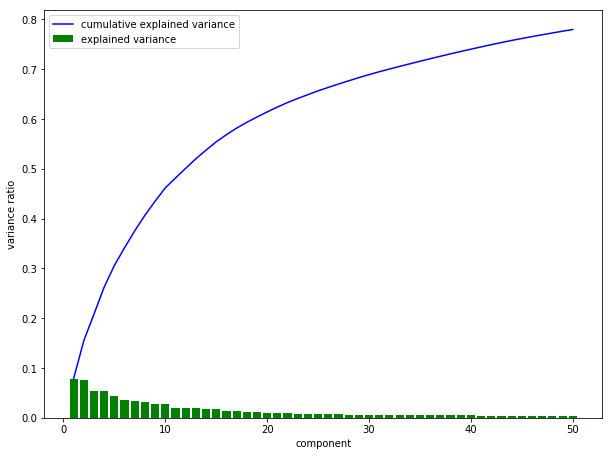

In [36]:
investigate_svd(t_svd)

In [37]:
def mk_svd_df(svd, original_df):
    '''
    Creates dataframe with each component of the svd matrix
    '''
    component_names = ['component_' + str(i +1) for i in range(50)]
    svd_df = pd.DataFrame(svd,
                          columns = component_names)
    svd_df.insert(0, 'track_id', original_df.index)
    return svd_df

In [38]:
svd_df = mk_svd_df(svdg, g_dummies)

In [40]:
svd_df.to_csv('../data/interim/genres/compressed_genres/genre_svd_df_20190824.csv')

### 1g. Bringing in Song Features

In [11]:
from library.song_feat_pull import *

In [4]:
get_song_feats('../data/song_features')

100 files completed
200 files completed
300 files completed
400 files completed
500 files completed
600 files completed
700 files completed
800 files completed
900 files completed
1000 files completed
1100 files completed
1200 files completed
1300 files completed
1400 files completed
1500 files completed
1600 files completed
1700 files completed
1800 files completed
1900 files completed
2000 files completed
2100 files completed
2200 files completed
2300 files completed
2400 files completed
2500 files completed
2600 files completed
2700 files completed
2800 files completed
2900 files completed
3000 files completed
3100 files completed
3200 files completed
3300 files completed
3400 files completed
3500 files completed
3600 files completed
3700 files completed
3800 files completed
3900 files completed
4000 files completed
4100 files completed
4200 files completed
4300 files completed
4400 files completed
4500 files completed
4600 files completed
4700 files completed
4800 files completed
4

In [8]:
import json

with open('../data/interim/song_features/features_20190805.json', 'r') as f:
    song_feats_dict = json.load(f)

In [9]:
len(song_feats_dict)

651410

In [12]:
mk_song_feats_df('../data/interim/song_features/features_20190805.json')

### 1h. One-Hot Encoding Additional Features

In [13]:
def one_hot_encode_feats(ddf, column_names):
    '''
    Creates one-hot encoded features for specified columns in subset
    of dask dataframe
    '''
    if isinstance(ddf, pd.core.frame.DataFrame):
        ddf = dd.from_pandas(ddf)
    
    ddf = ddf.categorize(columns = column_names)
    de = DummyEncoder(columns = column_names)
    
    print('forcing categorical values')
    dummies = de.fit_transform(ddf[column_names])
    
    print('merging dummies back into other features')
    ddf = ddf.drop(column_names, 1)\
             .merge(dummies)
    
    return ddf

In [14]:
song_features_ddf = dd.read_csv('../data/interim/song_features/song_features_20190805.csv')\
                        .rename(columns = {'Unnamed: 0' : 'track_id'})

In [15]:
song_features_ddf.head()

,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2M3alDEGZMbCl5lzelRx2I,0.0093,0.748,221920,0.879,0.0000,2,0.313,-6.312,1,0.3070,168.907,4,0.726
1,5fLqHl6NQ8ALBxJBhEGPdQ,0.0304,0.617,159179,0.657,0.0000,0,0.151,-5.596,1,0.0315,97.063,4,0.878
2,4EiaQVZu0bcmBSHymKjRjK,0.0415,0.657,228973,0.867,0.0000,5,0.084,-4.670,0,0.0763,81.322,4,0.862
3,3iGMczstfQTLDkZw4300dW,0.7650,0.537,169267,0.870,0.0026,4,0.973,-4.735,1,0.1940,111.207,4,0.611
4,6mgevsdxj1IjjJ2WKYJfaH,0.4670,0.466,195027,0.478,0.0000,9,0.437,-7.863,1,0.0333,144.838,4,0.467


In [18]:
song_features_ddf = one_hot_encode_feats(song_features_ddf, ['key', 'time_signature'])

forcing categorical values
merging dummies back into other features


In [19]:
song_features_ddf.columns

Index(['track_id', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'key_2', 'key_0', 'key_5', 'key_4', 'key_9',
       'key_10', 'key_7', 'key_8', 'key_3', 'key_11', 'key_6', 'key_1',
       'time_signature_4', 'time_signature_3', 'time_signature_1',
       'time_signature_5', 'time_signature_0'],
      dtype='object')

In [20]:
song_features_df = song_features_ddf.compute()

In [21]:
song_features_df.to_csv('../data/interim/song_features/song_features_encoded_20190805.csv')

In [44]:
type(song_features_df)

pandas.core.frame.DataFrame

### 1i. Combining Dataset 

In [10]:
# segment_df = pd.read_csv('../data/segment_df_20190516.csv')
segment_df = pd.read_csv('../data/interim/analysis_segments/segment_df_20190413.csv', index_col=0)
segment_df.head()

,pm_0,pm_1,pm_2,pm_3,pm_4,pm_5,pm_6,pm_7,pm_8,pm_9,...,tv_2,tv_3,tv_4,tv_5,tv_6,tv_7,tv_8,tv_9,tv_10,tv_11
0007aPK8VmXN4ycL2OcBFa,0.514743,0.527414,0.490981,0.425309,0.489327,0.589119,0.459107,0.573878,0.385958,0.408154,...,1268.630838,656.186601,500.566239,536.456377,338.651487,174.695619,142.277493,138.032933,138.648659,135.472111
0008G8TW7eiVfwlRRsKlgW,0.309991,0.484581,0.166534,0.313087,0.167928,0.298984,0.306283,0.200908,0.400119,0.177900,...,1341.667694,974.575508,742.233070,378.294065,481.482576,277.078079,234.939623,221.397784,163.120339,265.294679
000BqzNd7gRYnK6umzTNZX,0.500833,0.538402,0.415921,0.403829,0.429524,0.301693,0.406960,0.356274,0.453748,0.461190,...,954.964606,1298.020425,604.104299,543.491840,460.702894,377.717478,123.443280,195.896173,169.778158,166.866359
000CSIqE1KcjAiZYYWXV18,0.420954,0.366707,0.457164,0.247320,0.357645,0.322342,0.323946,0.448164,0.275648,0.425867,...,1229.086105,1085.556691,511.778510,594.257976,277.330428,315.120957,267.671151,218.838587,176.195824,153.689841
000G1xMMuwxNHmwVsBdtj1,0.583816,0.527922,0.404993,0.425852,0.503034,0.336589,0.252259,0.327019,0.387718,0.386472,...,1729.689733,891.060505,392.514422,463.464531,493.520635,234.180976,198.796685,166.093593,150.744838,233.585150


In [24]:
segment_df.shape

(659529, 49)

In [7]:
matched_tracks_df = pd.read_csv('../data/interim/tracks_w_writers/matched_tracks_w_writers_20190422.csv', index_col=0)
matched_tracks_df.head()

,track_id,Song Title,Artist,artist_id,name,popularity,followers,artist_name,song_id,song_title,CID,PID,Title,Performer Name,WID,Writer Name,IPI,PRO
0,0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405,toto,0007aPK8VmXN4ycL2OcBFa,bodhisattva,126127,6030,bodhisattva,toto,7280,BECKER WALTER CARL,89150949.0,ASCAP
1,4F6419huGNh7rXB8Kr1rBf,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405,toto,4F6419huGNh7rXB8Kr1rBf,bodhisattva,126127,6030,bodhisattva,toto,7280,BECKER WALTER CARL,89150949.0,ASCAP
2,6auUOYXyP76l4fiqC86c9E,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405,toto,6auUOYXyP76l4fiqC86c9E,bodhisattva,126127,6030,bodhisattva,toto,7280,BECKER WALTER CARL,89150949.0,ASCAP
3,10JB78fwqaUrCFZj3XNn6L,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480,steely dan,10JB78fwqaUrCFZj3XNn6L,bodhisattva,126127,1699,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949.0,ASCAP
4,6cdLlECd80adBM3fgEk9Km,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480,steely dan,6cdLlECd80adBM3fgEk9Km,bodhisattva,126127,1699,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949.0,ASCAP


In [9]:
genre_svd_df = pd.read_csv('../data/interim/genres/compressed_genres/genre_svd_df_20190824.csv', index_col=0)
genre_svd_df.head()

,track_id,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,component_50
0,0007aPK8VmXN4ycL2OcBFa,1.42299,-0.079901,-0.200605,-0.205593,0.26224,0.136606,-0.165316,0.041852,-0.078251,...,0.006097,-0.018128,-0.040357,-0.074803,-0.306596,0.056499,-0.25455,0.114216,-0.052138,0.058043
1,4F6419huGNh7rXB8Kr1rBf,1.42299,-0.079901,-0.200605,-0.205593,0.26224,0.136606,-0.165316,0.041852,-0.078251,...,0.006097,-0.018128,-0.040357,-0.074803,-0.306596,0.056499,-0.25455,0.114216,-0.052138,0.058043
2,6auUOYXyP76l4fiqC86c9E,1.42299,-0.079901,-0.200605,-0.205593,0.26224,0.136606,-0.165316,0.041852,-0.078251,...,0.006097,-0.018128,-0.040357,-0.074803,-0.306596,0.056499,-0.25455,0.114216,-0.052138,0.058043
3,00LEpojkN28l3W4axF8Ish,1.42299,-0.079901,-0.200605,-0.205593,0.26224,0.136606,-0.165316,0.041852,-0.078251,...,0.006097,-0.018128,-0.040357,-0.074803,-0.306596,0.056499,-0.25455,0.114216,-0.052138,0.058043
4,0R56f7PIJwzIc8N15RUodh,1.42299,-0.079901,-0.200605,-0.205593,0.26224,0.136606,-0.165316,0.041852,-0.078251,...,0.006097,-0.018128,-0.040357,-0.074803,-0.306596,0.056499,-0.25455,0.114216,-0.052138,0.058043


In [12]:
song_features = pd.read_csv('../data/interim/song_features/song_features_encoded_20190805.csv', index_col=0)
song_features.head()

,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,key_8,key_3,key_11,key_6,key_1,time_signature_4,time_signature_3,time_signature_1,time_signature_5,time_signature_0
0,5xrLpM84zbiHQyhzUr73Os,0.6040,0.672,194374,0.710,0.0000,0.673,-11.116,1,0.0373,...,0,0,0,0,0,1,0,0,0,0
0,5xrLpM84zbiHQyhzUr73Os,0.6040,0.672,194374,0.710,0.0000,0.673,-11.116,1,0.0373,...,0,0,0,0,0,1,0,0,0,0
0,2M3alDEGZMbCl5lzelRx2I,0.0093,0.748,221920,0.879,0.0000,0.313,-6.312,1,0.3070,...,0,0,0,0,0,1,0,0,0,0
0,2M3alDEGZMbCl5lzelRx2I,0.0093,0.748,221920,0.879,0.0000,0.313,-6.312,1,0.3070,...,0,0,0,0,0,1,0,0,0,0
2,46lWZGgPm3Y1LMDig3OIQ5,0.6910,0.193,263707,0.464,0.0265,0.239,-11.273,1,0.0360,...,0,0,0,0,0,1,0,0,0,0


In [3]:
merged_df = mk_dataset('../data/interim/tracks_w_writers/matched_tracks_w_writers_20190422.csv',
                       '../data/interim/genres/compressed_genres/genre_svd_df_20190824.csv',
                       '../data/interim/analysis_segments/segment_df_20190413.csv',
                       '../data/interim/song_features/song_features_encoded_20190805.csv')

Combining datasets
Computing dataset
Normalizing values per songwriter
Combining final datasets


In [4]:
merged_df.shape

(546505, 143)

In [5]:
merged_df.to_csv('../data/modeling/WID_normalized_tracks_20190825.csv', index=False)

In [10]:
where_null = list(merged_df.isnull().any())

## 2. Scaling by "AVG" Songwriter Value for each Songwriter

Update 8/25/19: This was previously done with the below. However, the `mk_dataset` function now incorporates scaling by WID 

In [8]:
# Do not use -- at least while running in a container.

# client = Client('scheduler:8786')

In [10]:
matched_w_writers = pd.read_csv('../data/matched_tracks_w_writers_20190422.csv', index_col = 0)

In [24]:
matched_w_writers = matched_w_writers.applymap(lambda x: np.NaN if x == '—' else x)

In [33]:
matched_w_writers.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, Unnamed: 0 to PRO
dtypes: object(12), float64(3), int64(4)

In [28]:
matched_w_writers['IPI'] = matched_w_writers['IPI'].astype(pd.Int32Dtype())

In [30]:
matched_w_writers.to_csv('../data/matched_tracks_w_writers_20190504.csv')

In [ ]:
# see imports on 1f.
# not even sure if I need anything outside of the `read_csv`
# from pandas.arrays import IntegerArray

# # The actual registration that would be done in the 3rd-party library
# from dask.dataframe.extensions import make_array_nonempty

# @make_array_nonempty.register(IntegerArray)
# def _(dtype):
#     return integer_array([0, None], dtype=dtype)

matched_w_writers = dd.read_csv('../data/matched_tracks_w_writers_20190504.csv',
                                dtype = {
                                    'track_id' : str,
                                    'Song Title' : str,
                                    'Artist' : str,
                                    'artist_id' : str,
                                    'name' : str,
                                    'popularity' : np.int8,
                                    'followers' : np.int32,
                                    'artist_name' : str,
                                    'song_id' : str,
                                    'song_title' : str,
                                    'CID' : np.int32,
                                    'PID' : np.int32,
                                    'Title': str,
                                    'Performer Name' : str,
                                    'WID' : np.int32,
                                    'Writer Name' : str,
                                    'IPI': pd.Int32Dtype(),
                                    'PRO' : 'category'
                                    })\
                      .rename(columns = {'Unnamed: 0' : 'index'})\
                      .set_index('index')

In [7]:
matched_w_writers.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 18 entries, track_id to PRO
dtypes: category(1), Int32(1), object(11), int32(4), int8(1)

In [15]:
matched_with_writers_numeric = matched_w_writers[['popularity', 'followers', 'CID', 'PID', 'WID']]

In [10]:
grouped_vals_avgs_ddf = matched_with_writers_numeric.groupby('WID').mean()

In [11]:
grouped_vals_avgs_ddf.head()

,popularity,followers,CID,PID
WID,,,,
1,63.555556,1.380916e+06,140022.111111,23343.222222
2,55.500000,4.530500e+05,23335.500000,240.500000
3,65.304762,8.502829e+05,73315.723810,14429.009524
4,67.264706,8.245521e+05,22609.264706,16.970588
5,67.621212,1.039455e+06,27845.575758,3303.651515


In [28]:
def normalize_sngwriter(ddf):
    subset_ddf = ddf.drop(columns = ['track_id',
                          'Song Title',
                          'Artist',
                          'artist_id',
                          'name',
                          'popularity',
                          'followers',
                          'artist_name',
                          'song_id',
                          'song_title',
                          'CID',
                          'PID',
                          'Title',
                          'Performer Name',
                          'Writer Name',
                          'IPI',
                          'PRO'])
    grouped_vals_ddf = subset_ddf.groupby('WID').transform(lambda x: (x - x.mean()) / x.std() if x.std() is not 0 else 0) #Has been edited since it's last been run - see jj_linux branch for more info
    return grouped_vals_ddf

In [5]:
def normalize_sngwriter_df(ddf):
    grouped_vals_ddf = ddf.groupby('WID').transform(lambda x: (x - x.mean()) / x.std())

In [29]:
normalized_by_sngwriter_df = normalize_sngwriter(merged_df_ready)

In [30]:
# normalized_by_sngwriter_df.to_csv('../data/interim/normalized_vector_20190516.csv')

In [44]:
normalized_by_sngwriter_df.shape

(577426, 126)

In [24]:
metadata_df = merged_df[['track_id',
                          'Song Title',
                          'Artist',
                          'artist_id',
                          'name',
                          'popularity',
                          'followers',
                          'artist_name',
                          'song_id',
                          'song_title',
                          'CID',
                          'PID',
                          'Title',
                          'Performer Name',
                          'Writer Name',
                          'IPI',
                          'PRO']]

In [25]:
metadata_df.to_csv('../data/modeling/metadata_for_scaled_ddf_20190825.csv')

##### Detecting Null Values 

In [17]:
merged_df.isnull().agg('sum')

track_id            0
Song Title          0
Artist              0
artist_id           0
name                0
                   ..
time_signature_4    0
time_signature_3    0
time_signature_1    0
time_signature_5    0
time_signature_0    0
Length: 143, dtype: int64

In [45]:
normalized_by_sngwriter_df.isnull().agg('sum')

component_1          81530
component_2          87139
component_3          93384
component_4          87833
component_5          85671
component_6          89459
component_7          87992
component_8          89366
component_9          86899
component_10         88352
component_11         84486
component_12         87718
component_13         88319
component_14         82288
component_15         87549
component_16         87390
component_17         88073
component_18         85157
component_19         82286
component_20         91339
component_21         91090
component_22         83418
component_23         87957
component_24         86513
component_25         90215
component_26         87249
component_27         88837
component_28         86229
component_29         84643
component_30         85742
                     ...  
tv_10                14535
tv_11                14556
acousticness         14808
danceability         15077
duration_ms          17012
energy               14961
i

In [14]:
merged_df.fillna(value=0, inplace=True)

In [60]:
normalized_by_sngwriter_df.fillna(value = 0, inplace = True)

In [15]:
merged_df.to_csv('../data/modeling/WID_normalized_tracks_w_zeros_201908025.csv', index=False)

In [36]:
def mk_full_normalized_dataset(normalized_df, original_df):
    full_normalized_df = pd.concat([original_df[['track_id',
                          'Song Title',
                          'Artist',
                          'artist_id',
                          'name',
                          'popularity',
                          'followers',
                          'artist_name',
                          'song_id',
                          'song_title',
                          'CID',
                          'PID',
                          'Title',
                          'Performer Name',
                          'Writer Name',
                          'IPI',
                          'PRO']], normalized_df],
                         axis = 1)
    return full_normalized_df

In [37]:
full_normalized_df = mk_full_normalized_dataset(normalized_by_sngwriter_df, merged_df_ready)

In [40]:
full_normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577426 entries, 0 to 57473
Columns: 143 entries, track_id to time_signature_0
dtypes: float64(130), int64(1), object(12)
memory usage: 634.4+ MB


In [62]:
full_normalized_df.to_csv('../data/interim/full_normalized_tracks_20190516.csv')

## 3. Scaling Dataset 

In [16]:
from dask_ml.preprocessing import StandardScaler

In [65]:
def scale_dataset(ddf):
    ss = StandardScaler()
    scaled_ddf = ss.fit_transform(ddf)
    return scaled_ddf

In [19]:
scaled_df = scale_dataset(merged_df.drop(['track_id',
                          'Song Title',
                          'Artist',
                          'artist_id',
                          'name',
                          'popularity',
                          'followers',
                          'artist_name',
                          'song_id',
                          'song_title',
                          'CID',
                          'PID',
                          'Title',
                          'Performer Name',
                          'Writer Name',
                          'IPI',
                          'PRO'], axis=1))

In [21]:
scaled_df.shape

(546505, 126)

In [23]:
scaled_df.to_csv('../data/modeling/scaled_ddf_20190825.csv')